In [1]:
# imports
import torch
import random
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.model_selection import KFold
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [2]:
# TODO:Split it into traing and vaildating set
generator1 = torch.Generator().manual_seed(42)

x = pd.read_csv('./radio_train/input_data.csv', names=[i for i in range(16)], dtype=float)
y = pd.read_csv('./radio_train/target_data.csv', names=["y1", "y2", 2], dtype=float)
y = y.drop(columns=2)
xy = pd.concat([x, y], axis=1)

x = torch.FloatTensor(xy[[x for x in range(16)]].values)
y = torch.FloatTensor(xy[["y1", "y2"]].values)

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [3]:
# defining model

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 8),
            nn.Tanh(),
            nn.Linear(8, 2),
            nn.Tanh()
        )
        
    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

   # takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

    

model = NeuralNetwork().to(device)
model.apply(weights_init_uniform_rule)
print(model)


NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): Tanh()
    (4): Linear(in_features=8, out_features=2, bias=True)
    (5): Tanh()
  )
)


In [4]:
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 100
losses = []

# print(model.forward(x[0]))

criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
num_epochs = 5000

history = {"loss": []}
for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(x.float())
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch + 1}/{num_epochs} Loss: {loss.item()}')
    history["loss"].append(loss.item())
    clear_output(wait=True)

Epoch 5000/5000 Loss: 4.969600558979437e-05


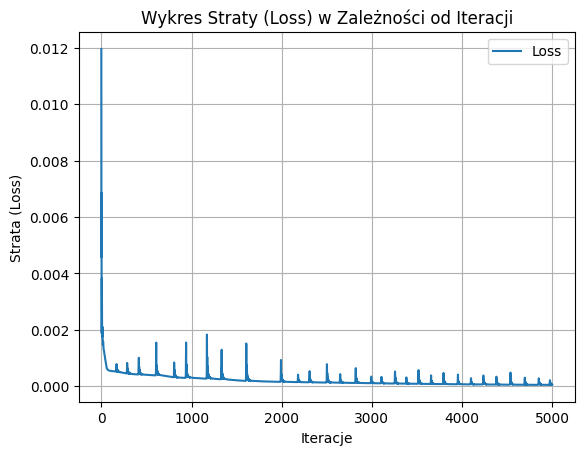

4.969600558979437e-05


In [5]:
plt.plot([x for x in range(5000)], history["loss"], label='Loss')
plt.title('Wykres Straty (Loss) w Zależności od Iteracji')
plt.xlabel('Iteracje')
plt.ylabel('Strata (Loss)')
plt.legend()
plt.grid(True)
plt.show()

print(history["loss"][-1])

torch.save(model.state_dict(), 'trained_model.pth')

In [12]:
optimizers = [
    {"val": optim.SGD(model.parameters(), lr=0.6),
     "name": "SGD lr=0.6 momentum=0.9"},
    {"val": torch.optim.Adam(model.parameters(), lr=0.3),
     "name": "Adam lr 0.1"},
    {"val": torch.optim.Adam(model.parameters(), lr=0.3),
     "name": "Adam lr 0.3"},
    {"val": optim.SGD(model.parameters(), lr=0.6, momentum=0.9),
     "name": "SGD lr=0.4 momentum=0.9"}
]
# stochastic gradient descent
networks_shapes = [
    {"val": nn.Sequential(
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Linear(32, 8),
            nn.Tanh(),
            nn.Linear(8, 2),
            nn.Tanh()
        ),
    "name": "32-8"},
    {"val": nn.Sequential(
            nn.Linear(16, 64),
            nn.Tanh(),
            nn.Linear(64, 256),
            nn.Tanh(),
            nn.Linear(256, 64),
            nn.Tanh(),
            nn.Linear(64, 8),
            nn.Tanh(),
            nn.Linear(8, 2),
            nn.Tanh()
        ),
    "name": "64-256-64-8"},
    {"val": nn.Sequential(
            nn.Linear(16, 128),
            nn.Tanh(),
            nn.Linear(128, 8),
            nn.Tanh(),
            nn.Linear(8, 2),
            nn.Tanh()
        ),
    "name": "128-8"} 
]

Fold 1/4 - Last Epoch Training Loss: 0.0043173059821128845, Validation Loss: 0.004300277680158615
True: 0.008332774974405766, 0.009511228650808334
Pred: -0.07966910302639008, 0.09212295711040497
Fold 2/4 - Last Epoch Training Loss: 0.0057052806951105595, Validation Loss: 0.005713103339076042
True: 0.006617660168558359, 0.05628501623868942
Pred: -0.0018686109688133001, -0.03246079012751579
Fold 3/4 - Last Epoch Training Loss: 0.004705663304775953, Validation Loss: 0.004867066163569689
True: 0.019097628071904182, -0.025766776874661446
Pred: -0.10707610100507736, -0.039323460310697556
Fold 4/4 - Last Epoch Training Loss: 0.0016928327968344092, Validation Loss: 0.0023339048493653536
True: -0.04914947226643562, 0.035108331590890884
Pred: 0.0004889771225862205, -0.0013148549478501081


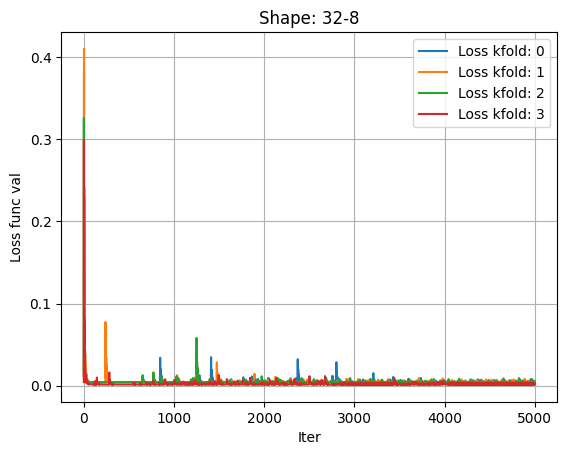

Fold 1/4 - Last Epoch Training Loss: 0.004310098942369223, Validation Loss: 0.004321989603340626
True: 0.012881102971732616, -0.006670048460364342
Pred: 0.09336797893047333, -0.0044822390191257
Fold 2/4 - Last Epoch Training Loss: 0.005824584048241377, Validation Loss: 0.005891980137676001
True: 0.002589160343632102, -0.06236468628048897
Pred: 0.11458619683980942, 0.03563794866204262
Fold 3/4 - Last Epoch Training Loss: 0.00442627165466547, Validation Loss: 0.004629801958799362
True: 0.006238558329641819, -0.02194989286363125
Pred: 0.04616720974445343, 0.020328929647803307
Fold 4/4 - Last Epoch Training Loss: 0.005209604278206825, Validation Loss: 0.005601956974714994
True: 0.008620555512607098, -0.04821380227804184
Pred: -0.0961722582578659, 0.034054260700941086


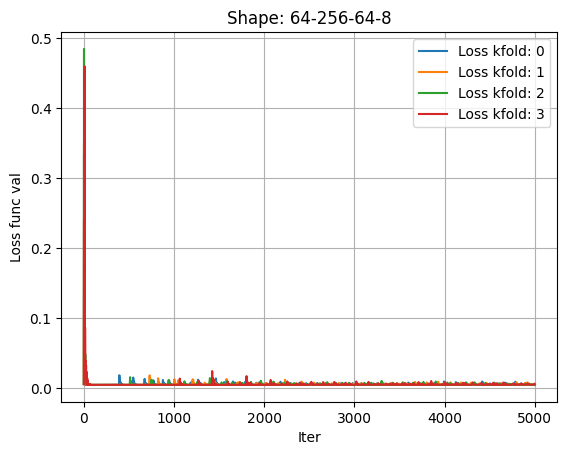

Fold 1/4 - Last Epoch Training Loss: 0.005030693951994181, Validation Loss: 0.00523329246789217
True: 0.008007489144802094, -0.04391389340162277
Pred: -0.12446340173482895, 0.0007967337733134627
Fold 2/4 - Last Epoch Training Loss: 0.004628455266356468, Validation Loss: 0.0042379023507237434
True: 0.005115106701850891, -0.021203884854912758
Pred: 0.09346620738506317, -0.10372690111398697
Fold 3/4 - Last Epoch Training Loss: 0.004366617649793625, Validation Loss: 0.004717047791928053
True: -0.009133233688771725, 0.019690917804837227
Pred: -0.08379489183425903, -0.023486539721488953
Fold 4/4 - Last Epoch Training Loss: 0.004268405959010124, Validation Loss: 0.004273941740393639
True: -0.015318223275244236, 0.001249655382707715
Pred: -0.08143729716539383, 0.03194266930222511


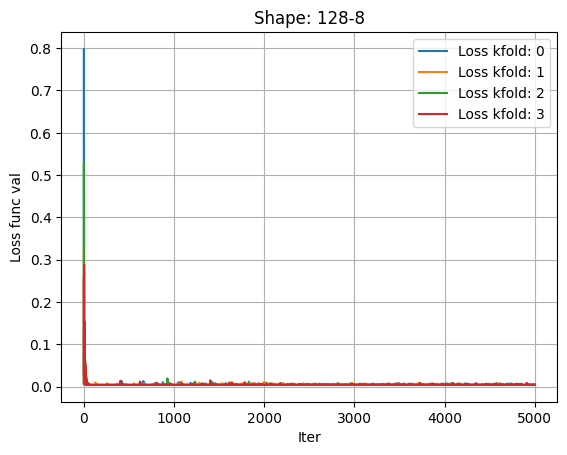

In [16]:
def train_model(model, x_train, y_train, x_val, y_val, num_epochs=5000):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    history = {"train_loss": [], "val_loss": []}
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(x_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        history["train_loss"].append(loss.item())

        model.eval()
        val_output = model(x_val)
        val_loss = criterion(val_output, y_val)
        history["val_loss"].append(val_loss.item())
        # if epoch == num_epochs-1:
        #     print(f'Epoch {epoch + 1}/{num_epochs} Loss: {loss.item()}')
    
    return model, history

k_folds = 4

kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)


for model_arch in networks_shapes:
    for fold, (train_idx, val_idx) in enumerate(kfold.split(x)):
        x_train, x_val = x[train_idx], x[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
    
        model = NeuralNetwork().to(device)
        model.linear_relu_stack = model_arch['val']
        model.apply(weights_init_uniform_rule)
        model, history = train_model(model, x_train, y_train, x_val, y_val)
            
        plt.plot([x for x in range(5000)], history["train_loss"], label=f'Loss kfold: {fold}')
        plt.title(f"Shape: {model_arch['name']}")
        plt.xlabel('Iter')
        plt.ylabel('Loss func val')
        plt.grid(True)
        
        
    
        print(f'Fold {fold + 1}/{k_folds} - Last Epoch Training Loss: {history["train_loss"][-1]}, Validation Loss: {history["val_loss"][-1]}')
        for i in range(1):
            j = np.random.randint(0, 2159)
            print(f"True: {model(x[j])[0]}, {model(x[j])[1]}")
            print(f"Pred: {y[j][0]}, {y[j][1]}")
    plt.legend()
    plt.show()
